# Who are the debt collectors?

Looking into future work reguarding case names.

Last ran (05-01-2024)

In [29]:
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

cnx = pymysql.connect(user='buspark', password='U@5p1r3!',
                              host='masscourtsplus.org',
                              database='civica_courtdocs')

cursor = cnx.cursor()

## New Method

Only capturing civil and small claims cases as per our discussion with the clients, PM, and TPM.

In [30]:
# TODO: add wp_post column
query = """

SELECT
    case_type,
    case_number,
    file_date,
    parties,
    wp_post_id
FROM
    cases_masscourts_org
WHERE
    case_type = 'Civil'
        OR
    case_type = 'Small Claims'
"""

%time

cursor.execute(query)

results = cursor.fetchall()

Wall time: 0 ns


Query time: 4m 36.3s

In [31]:
query = """

SELECT
    case_number
FROM
    cases_masscourts_org
"""

%time

cursor.execute(query)

results2 = cursor.fetchall()

allcases = pd.DataFrame(results)

n_cases_overall = len(allcases)

Wall time: 0 ns


In [32]:
cursor.close()

Example json blob for parties with key "parties":

```json
{
  "parties": [
    {
      "name": "Company",
      "party_type": "Plaintiff",
      "attorneys": [],
      "alias": "",
      "dod": null
    },
    {
      "name": "Lname, Fname M",
      "party_type": "Defendant",
      "attorneys": [],
      "alias": "",
      "dod": null
    }
  ]
}
```

In [33]:
cases = pd.DataFrame(results, columns=['case_type', 'case_number', 'file_date', 'parties', 'wp_post_id'])
print('Number of cases: ', len(cases))

# filter out cases where date is before 2013 
# code below breaks if uncommented at certain point for unknown reasons
# moved for stability over performance
# cases['file_date'] = pd.to_datetime(cases['file_date'])
# cases = cases[cases['file_date'] > '2013-01-01']

# json blob of parties to dictionary
dict_parties = cases['parties'].apply(lambda x: json.loads(x))

# create empty columns for plaintiff and defendant
cases['plaintiff'] = np.nan
cases['defendant'] = np.nan

# get defendent and plaintiff
for i in range(len(dict_parties)):
    if 'parties' not in dict_parties[i]:
        continue
    for j in range(len(dict_parties[i]['parties'])):
        party = dict_parties[i]['parties'][j]
        # if both plaintiff and defendant are found, break
        if not pd.isnull(cases.loc[i, 'plaintiff']) and not pd.isnull(cases.loc[i, 'defendant']):
            break
        if party['party_type'] == 'Plaintiff':
            cases.loc[i, 'plaintiff'] = str(party['name'])
        elif party['party_type'] == 'Defendant':
            cases.loc[i, 'defendant'] = party['name']

# filter out cases where date is before 2014
cases['file_date'] = pd.to_datetime(cases['file_date'])
cases = cases[cases['file_date'] > '2014-01-01']

cases.drop(columns=['parties'], inplace=True)
cases.head(5)

Number of cases:  2775874


,case_type,case_number,file_date,wp_post_id,plaintiff,defendant
0,Civil,2201CV001307,2022-10-06,89009856.0,Safety Insurance Company,"Loughlin, Mark A"
1,Small Claims,2208SC000228,2022-10-04,89009872.0,"Portfolio Recovery Associates, Llc","Sical, Byron Tobias"
2,Civil,2210CV001010,2022-10-03,89009882.0,"Midland Credit Management, Inc.","Williams, Hansel N."
3,Civil,2211CV000812,2022-10-04,89009895.0,American Express National Bank,Lourdes Amoga Win AKA Lourdes L Amoga Win
4,Small Claims,2214SC000981,2022-10-03,89009912.0,"Portfolio Recovery Associates, Llc","Guevara, Jomer"


execution time: 3m 49.9s

In [34]:
collectors_df = pd.read_csv('../data/debt-collector-licensee-filtered.csv')
debt_company = collectors_df['Suspected Name']
debt_cmp = [x.lower() for x in debt_company]

In [35]:
# convert any plaintiff to str as some are float for unknown reasons
cases['plaintiff'] = cases['plaintiff'].astype(str)

In [36]:
def check_company(row, lst):
    for company in lst:
        r = row.lower().replace('.', '').replace(',', ' ')
        r = ' '.join(r.split())    # ensure that there is only one space between words
        if company in r:
            return company
    return np.nan
cases['Debt Collector'] = np.nan
cases['Debt Collector'] = cases['plaintiff'].apply(check_company, lst = debt_cmp)

cases.head(5)

,case_type,case_number,file_date,wp_post_id,plaintiff,defendant,Debt Collector
0,Civil,2201CV001307,2022-10-06,89009856.0,Safety Insurance Company,"Loughlin, Mark A",NaN
1,Small Claims,2208SC000228,2022-10-04,89009872.0,"Portfolio Recovery Associates, Llc","Sical, Byron Tobias",portfolio recovery associates llc
2,Civil,2210CV001010,2022-10-03,89009882.0,"Midland Credit Management, Inc.","Williams, Hansel N.",midland credit management
3,Civil,2211CV000812,2022-10-04,89009895.0,American Express National Bank,Lourdes Amoga Win AKA Lourdes L Amoga Win,NaN
4,Small Claims,2214SC000981,2022-10-03,89009912.0,"Portfolio Recovery Associates, Llc","Guevara, Jomer",portfolio recovery associates llc


execution time: 3m 57.5s

In [37]:
cases['Debt Collector'] = cases['Debt Collector'].str.title()
cases['Debt Collector'] = cases['Debt Collector'].str.replace('Llc', 'LLC')
n_small_claims = len(cases[cases['case_type'] == 'Small Claims'])
n_civil = len(cases[cases['case_type'] == 'Civil'])
n_cases = cases.shape[0]
n_debt_collection_cases = cases['Debt Collector'].value_counts().sum()
print("Number of cases in court:", n_cases)
print("Number of debt collection cases in court:", n_debt_collection_cases)
print("Number of small claims cases in court:", n_small_claims)
print("Number of civil cases in court:", n_civil)
print("Percentage of debt collection cases in court:", n_debt_collection_cases/n_cases * 100)
print("Number of debt collection companies in court:", cases['Debt Collector'].nunique()) # delete
print("Percent of cases that are debt collection cases:", n_debt_collection_cases/n_cases_overall * 100)

# export csv of Debt Collectors not NaN
cases_debt_only = cases[cases['Debt Collector'].notnull()]
cases_debt_only.to_csv('../data/case_claims.csv', index=False)
# small claims cases by debt collection company
cases['Debt Collector'].value_counts().head(15)

Number of cases in court: 1185088
Number of debt collection cases in court: 591670
Number of small claims cases in court: 844219
Number of civil cases in court: 340869
Percentage of debt collection cases in court: 49.926250202516606
Number of debt collection companies in court: 143
Percent of cases that are debt collection cases: 21.314728262161754


Midland Funding LLC                  138059
Portfolio Recovery Associates LLC     96865
Lvnv Funding LLC                      95613
Capital One                           71382
Midland Credit Management             53554
Bank Of America                       19621
Td Bank                               13211
Cach LLC                              12007
Credit One Bank Na                    11963
Cavalry Portfolio Services LLC        11055
Waterfront Capital LLC                10501
Jefferson Capital Systems LLC          8650
Barclays Bank                          7212
Unifund Corporation                    6568
Crown Asset Management LLC             6270
Name: Debt Collector, dtype: int64

Number of debt collection cases in small claims: 482461


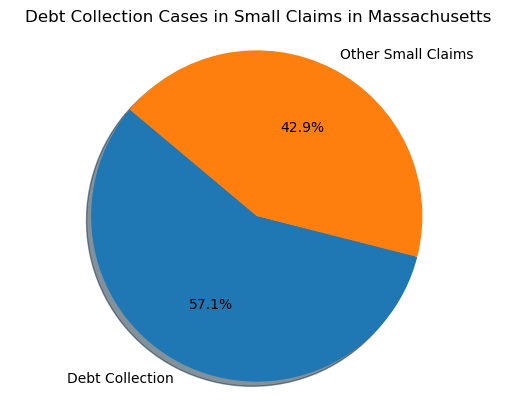

In [38]:
n_small_claims_cases = cases_debt_only[cases_debt_only['case_type'] == 'Small Claims'].shape[0]
print("Number of debt collection cases in small claims:", n_small_claims_cases)
n_small_claims_all = cases[cases['case_type'] == 'Small Claims'].shape[0]
labels = 'Debt Collection', 'Other Small Claims'
sizes = [n_small_claims_cases, n_small_claims_all - n_small_claims_cases]
# explode = (0.1, 0)
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Debt Collection Cases in Small Claims in Massachusetts')
plt.show()

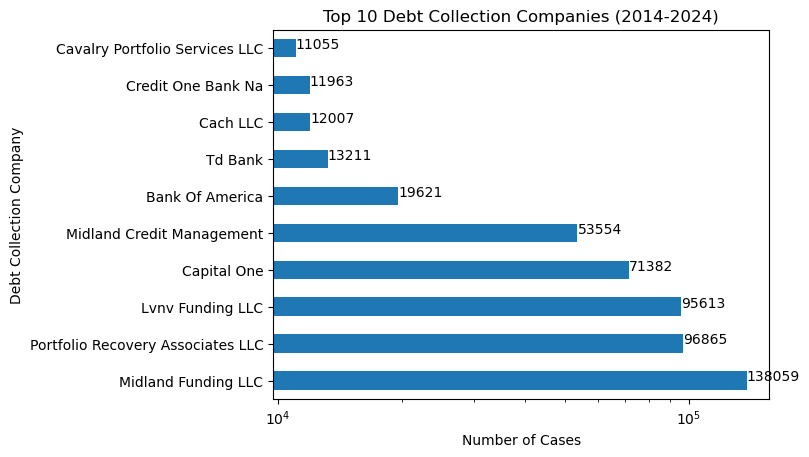

In [40]:
# horizontal bar graph of top 10 debt collection companies
fig, ax = plt.subplots()
cases['Debt Collector'].value_counts().head(10).plot(kind='barh', ax = ax)
for i, v in enumerate(cases['Debt Collector'].value_counts().head(10)):
    ax.text(v, i, str(v), ha = 'left')
ax.set_xscale('log')
ax.set_ylabel('Debt Collection Company')
ax.set_xlabel('Number of Cases')
ax.set_title('Top 10 Debt Collection Companies (2014-2024)')
plt.show()

## Previous Method

In [ ]:
query = """
SELECT
    case_type,
    case_title
FROM
    cases_masscourts_org
"""

%time

cursor.execute(query)

results = cursor.fetchall()

query time: 4m 37.3s

In [3]:
cases = pd.DataFrame(results)
# cases.rename({0: 'Case Number', 1: 'Department', 2: 'Case Title'}, axis = 1).head()

# collectors for last quarter of 2023
# collectors_df = pd.read_csv('../data/debt-collector-licensee-all.csv')
# debt_company = collectors_df['Company Name'].unique()
# debt_company = [x.lower() for x in debt_company]
# debt_cmp = [x.replace(',', '') for x in debt_company]
# debt_cmp = [x.replace('.', '') for x in debt_cmp]
collectors_df = pd.read_csv('../data/debt-collector-licensee-filtered.csv')
debt_company = collectors_df['Suspected Name']
debt_cmp = [x.lower() for x in debt_company]

In [4]:
def check_company(row, lst):
    for company in lst:
        r = row.lower().replace('.', '').replace(',', ' ')
        r = ' '.join(r.split())    # ensure that there is only one space between words
        if company in r:
            return company
    return np.nan

cases['Debt Collector'] = cases[1].apply(check_company, lst = debt_cmp)

cases.rename({0:'Case Type', 1:'Plaintiff'}, axis = 1).head()

,Case Type,Plaintiff,Debt Collector
0,Civil,2201CV001307 Safety Insurance Company vs. Loug...,NaN
1,Supplementary Process,"2207SP000027EF Boston Window & Door, Llc D/B/A...",NaN
2,Small Claims,"2208SC000228 Portfolio Recovery Associates, Ll...",portfolio recovery associates llc
3,Civil,"2210CV001010 Midland Credit Management, Inc. v...",midland credit management
4,Civil,2211CV000812 American Express National Bank v....,NaN


runtime: 29m 23.4s

In [5]:
n_cases = cases.shape[0]
n_debt_collection_cases = cases['Debt Collector'].value_counts().sum()
print("Number of cases in court:", n_cases)
print("Number of debt collection cases in court:", n_debt_collection_cases)
print("Percentage of debt collection cases in court:", n_debt_collection_cases/n_cases * 100)
print("Number of debt collection companies in court:", cases['Debt Collector'].nunique())
cases['Debt Collector'].value_counts().head(15)

Number of cases in court: 4927770
Number of debt collection cases in court: 859071
Percentage of debt collection cases in court: 17.43326088677028
Number of debt collection companies in court: 290


capital one                          202038
midland funding llc                  164513
portfolio recovery associates llc    126206
midland credit management             53489
credit one bank na                    53052
bank of america                       46764
us bank                               25682
idi                                   22094
td bank                               16156
waterfront capital llc                12849
barclays bank                         12013
cavalry portfolio services llc        11552
palisades collection llc              10377
unifund corporation                   10277
jefferson capital systems llc         10274
Name: Debt Collector, dtype: int64

In [6]:
cases['Debt Collector'] = cases['Debt Collector'].str.title()
cases['Debt Collector'] = cases['Debt Collector'].str.replace('Llc', 'LLC')

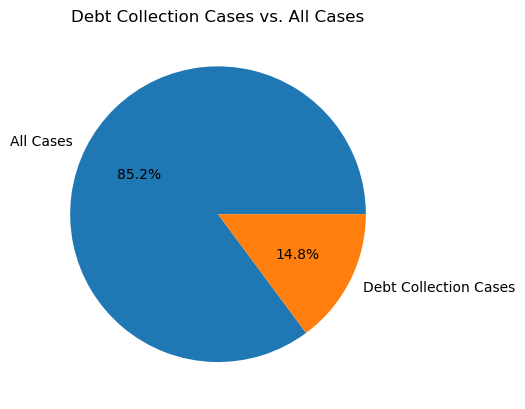

In [7]:
# pie chart of debt collection cases vs cases overall with percentage
fig, ax = plt.subplots()
# use n_cases and n_debt_collection_cases to calculate the percentage of debt collection cases
ax.pie([n_cases, n_debt_collection_cases], labels = ['All Cases', 'Debt Collection Cases'], autopct = '%1.1f%%')
ax.set_ylabel('')
plt.title('Debt Collection Cases vs. All Cases')
plt.show()

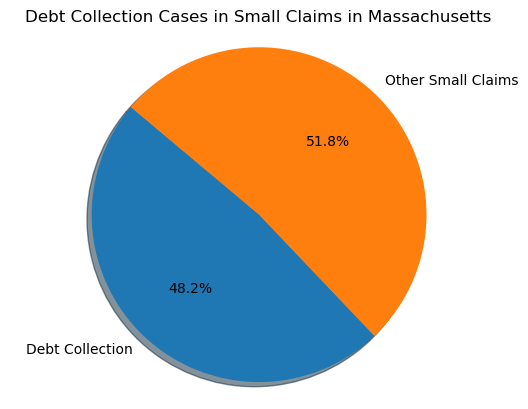

In [8]:
n_small_claims_cases = cases[cases[0] == 'Small Claims'].shape[0]
labels = 'Debt Collection', 'Other Small Claims'
sizes = [n_debt_collection_cases, n_small_claims_cases - n_debt_collection_cases]
# explode = (0.1, 0)
plt.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Debt Collection Cases in Small Claims in Massachusetts')
plt.show()

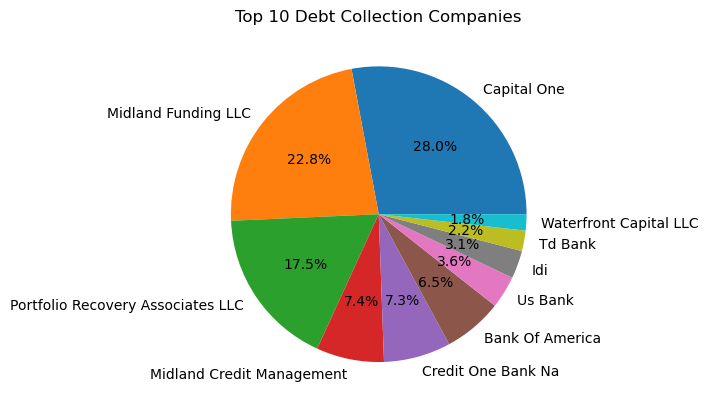

In [9]:
# pie chart of top 10 debt collection companies
fig, ax = plt.subplots()
cases['Debt Collector'].value_counts().head(10).plot.pie(autopct='%1.1f%%', ax = ax)
ax.set_ylabel('')
ax.set_title('Top 10 Debt Collection Companies')
plt.show()

In [10]:
# get cases in small claims and civil
small_claims_cases = cases[cases[0] == 'Small Claims']
civil_cases = cases[cases[0] == 'Civil']
court_cases = pd.concat([small_claims_cases, civil_cases])
# number of cases in small claims and civil
n_claims_cases = court_cases.shape[0]
n_claims_debt_collection_cases = court_cases['Debt Collector'].value_counts().sum()
print("Number of cases in court:", n_claims_cases)
print("Number of debt collection cases in court:", n_claims_debt_collection_cases)
print("Percentage of debt collection cases in court:", n_claims_debt_collection_cases/n_claims_cases * 100)
print("Number of debt collection companies in court:", court_cases['Debt Collector'].nunique())
# top 10 debt collection companies in small claims and civil
court_cases['Debt Collector'].value_counts().head(10)

Number of cases in court: 2773865
Number of debt collection cases in court: 724804
Percentage of debt collection cases in court: 26.12975036636606
Number of debt collection companies in court: 214


Capital One                          183438
Midland Funding LLC                  150784
Portfolio Recovery Associates LLC    120771
Midland Credit Management             53325
Credit One Bank Na                    53034
Bank Of America                       29561
Td Bank                               13871
Waterfront Capital LLC                11972
Barclays Bank                         11571
Idi                                   11081
Name: Debt Collector, dtype: int64

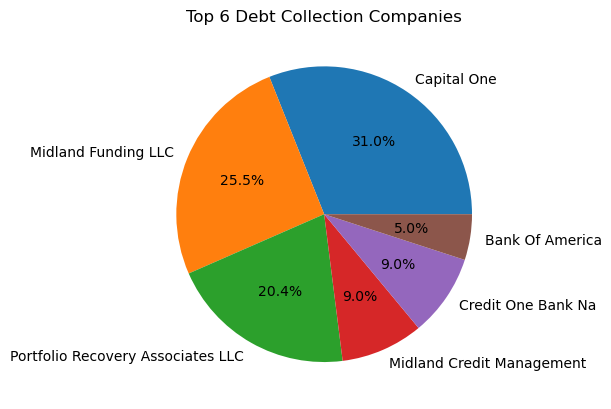

In [100]:
# pie chart of top 6 debt collection companies based on small claims and civil cases
fig, ax = plt.subplots()
court_cases['Debt Collector'].value_counts().head(6).plot.pie(autopct='%1.1f%%', ax = ax)
ax.set_ylabel('')
ax.set_title('Top 6 Debt Collection Companies')
plt.show()

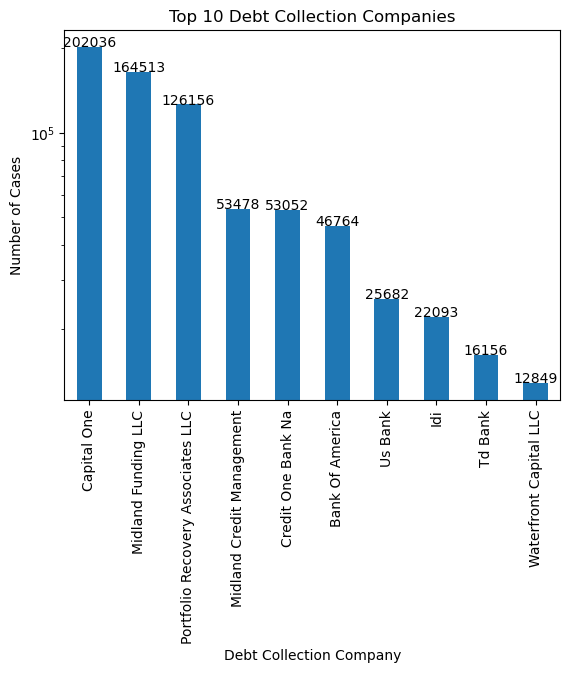

In [90]:
# bar graph of top 10 debt collection companies
fig, ax = plt.subplots()
cases['Debt Collector'].value_counts().head(10).plot(kind='bar', ax = ax)
for i, v in enumerate(cases['Debt Collector'].value_counts().head(10)):
    ax.text(i, v + 10, str(v), ha = 'center')
ax.set_yscale('log')
ax.set_xlabel('Debt Collection Company')
# ax.set_xscale('log')
ax.set_ylabel('Number of Cases')
ax.set_title('Top 10 Debt Collection Companies')
plt.show()

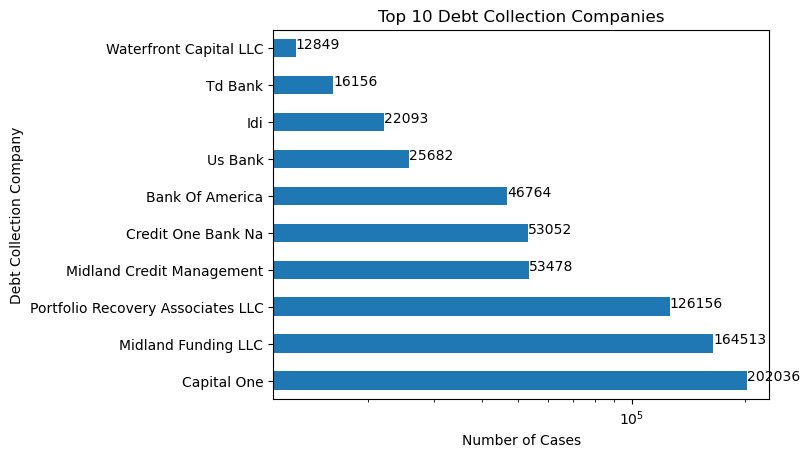

In [103]:
# horizontal bar graph of top 10 debt collection companies
fig, ax = plt.subplots()
cases['Debt Collector'].value_counts().head(10).plot(kind='barh', ax = ax)
for i, v in enumerate(cases['Debt Collector'].value_counts().head(10)):
    ax.text(v, i, str(v), ha = 'left')
ax.set_xscale('log')
ax.set_ylabel('Debt Collection Company')
ax.set_xlabel('Number of Cases')
ax.set_title('Top 10 Debt Collection Companies')
plt.show()

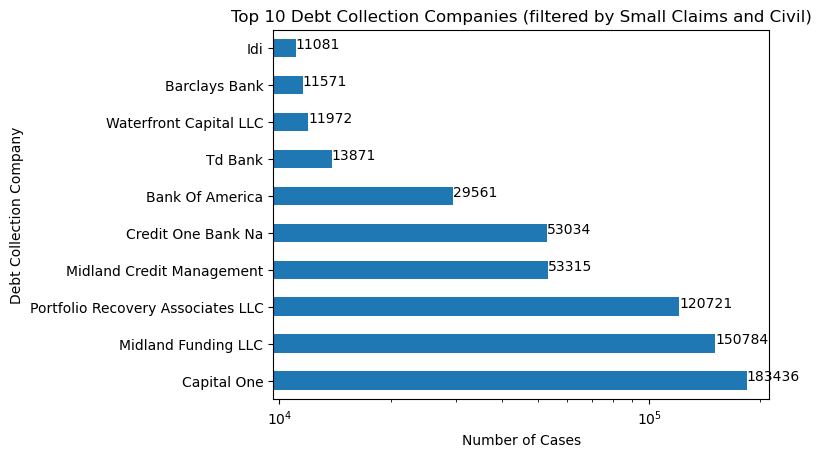

In [104]:
# horizontal bar graph of top 10 debt collection companies
fig, ax = plt.subplots()
court_cases['Debt Collector'].value_counts().head(10).plot(kind='barh', ax = ax)
for i, v in enumerate(court_cases['Debt Collector'].value_counts().head(10)):
    ax.text(v, i, str(v), ha = 'left')
ax.set_xscale('log')
ax.set_ylabel('Debt Collection Company')
ax.set_xlabel('Number of Cases')
ax.set_title('Top 10 Debt Collection Companies (filtered by Small Claims and Civil)')
plt.show()

In [14]:
# take out first word in case title to get case number
court_cases['Case Number'] = court_cases[1].str.split(' ').str[0]
# drop rows where debt collector is NaN
court_cases = court_cases.dropna(subset = ['Debt Collector'])
court_cases.to_csv('../data/case_claims.csv', index = False)

In [10]:
cases.to_csv('../data/case_titles.csv', index = False)

In [ ]:
cursor.close()